In [1]:
import locator
from locator import Locator, plot_predictions, plot_error_summary
import numpy as np, pandas as pd

In [2]:
# setup locator config
locator = Locator(
    {
        "out": "windows",
        "sample_data": "../data/test_sample_data.txt",
        "zarr": "../data/test_genotypes.zarr",
        "train_split": 0.9,
        "batch_size": 64,
        "keras_verbose": 0,
    }
)

No GPU devices available. Running on CPU.


In [3]:
# Load and sort data
genotypes, samples = locator.load_genotypes(
    vcf="../data/test_genotypes.vcf.gz",
    #zarr="../data/test_genotypes.zarr",
)


reading VCF


[read_vcf] 11527 rows in 0.23s; chunk in 0.23s (50162 rows/s)
[read_vcf] all done (50097 rows/s)


{'enabled': False, 'flip_rate': 0.05}
Predicting locations for holdout samples...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


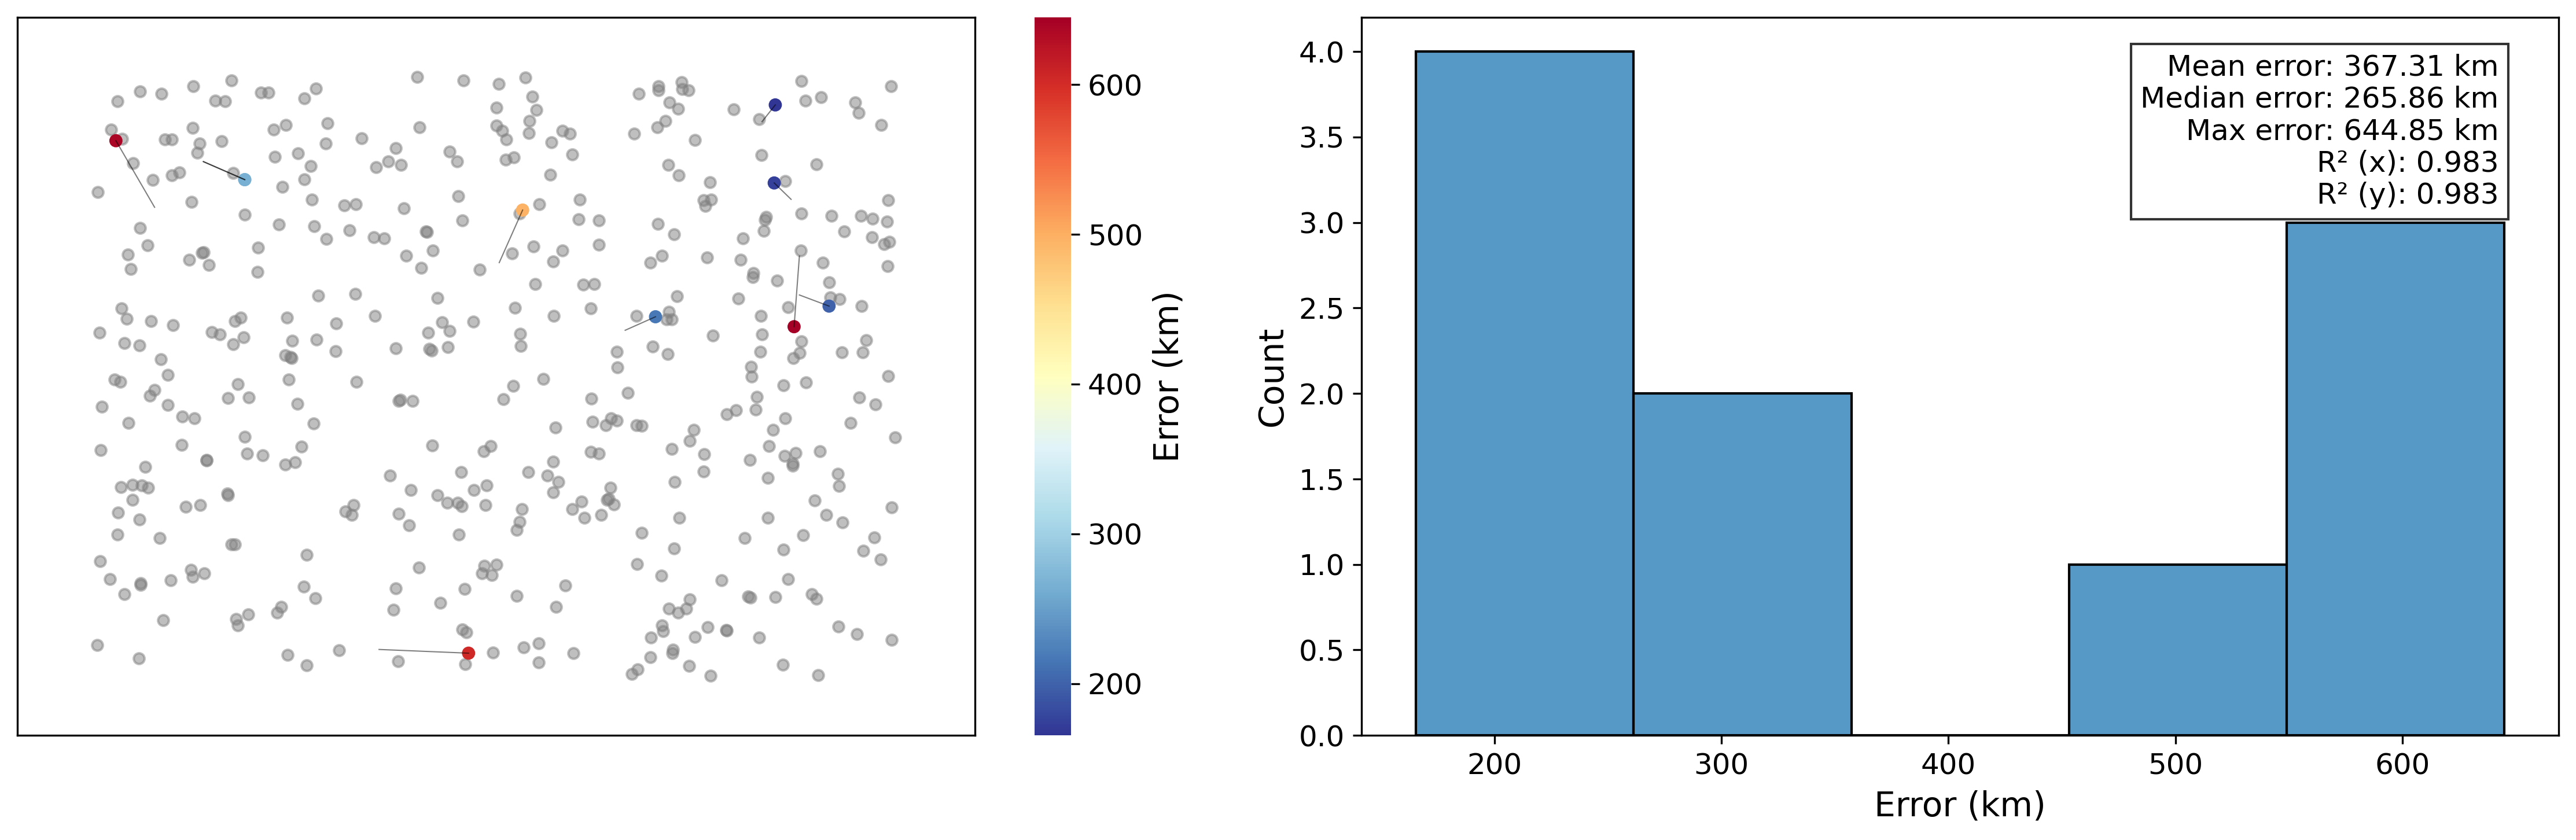

In [4]:
mask = ~np.isnan(locator.sample_data.x.values)
idxs = np.random.choice(np.arange(len(locator.sample_data))[mask], 10)
locator.train_holdout(genotypes, samples, holdout_indices=idxs)
predictions = locator.predict_holdout(return_df=True, plot_map=False)

Configuration,Value
train_split,0.9
batch_size,64
min_mac,2
max_SNPs,None
width,256
nlayers,8
dropout_prop,0.25
max_epochs,5000
optimizer_algo,adam
learning_rate,0.001

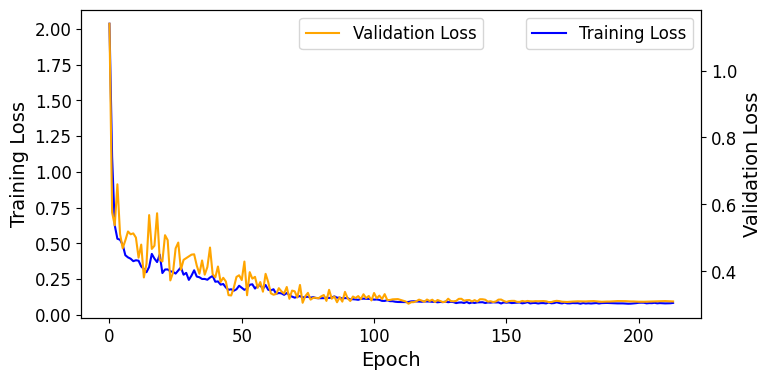

In [5]:
locator

In [6]:
from locator.utils import weight_samples
from locator import  plot_sample_weights

/Users/clararehmann/phd/research/ReLocator/locator/core.py:1355: UserWarning: Sample weights already calculated. 
                    Set locator.sample_weights to None in config to disable.
  warnings.warn(


{'enabled': False, 'flip_rate': 0.05}


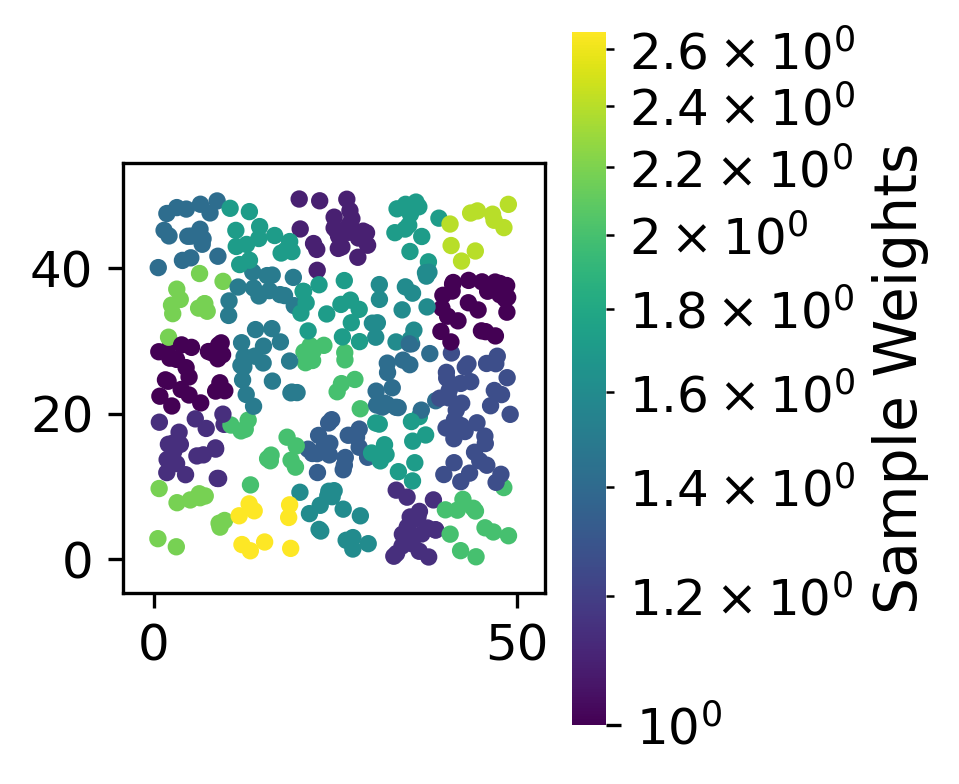

Predicting locations for holdout samples...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


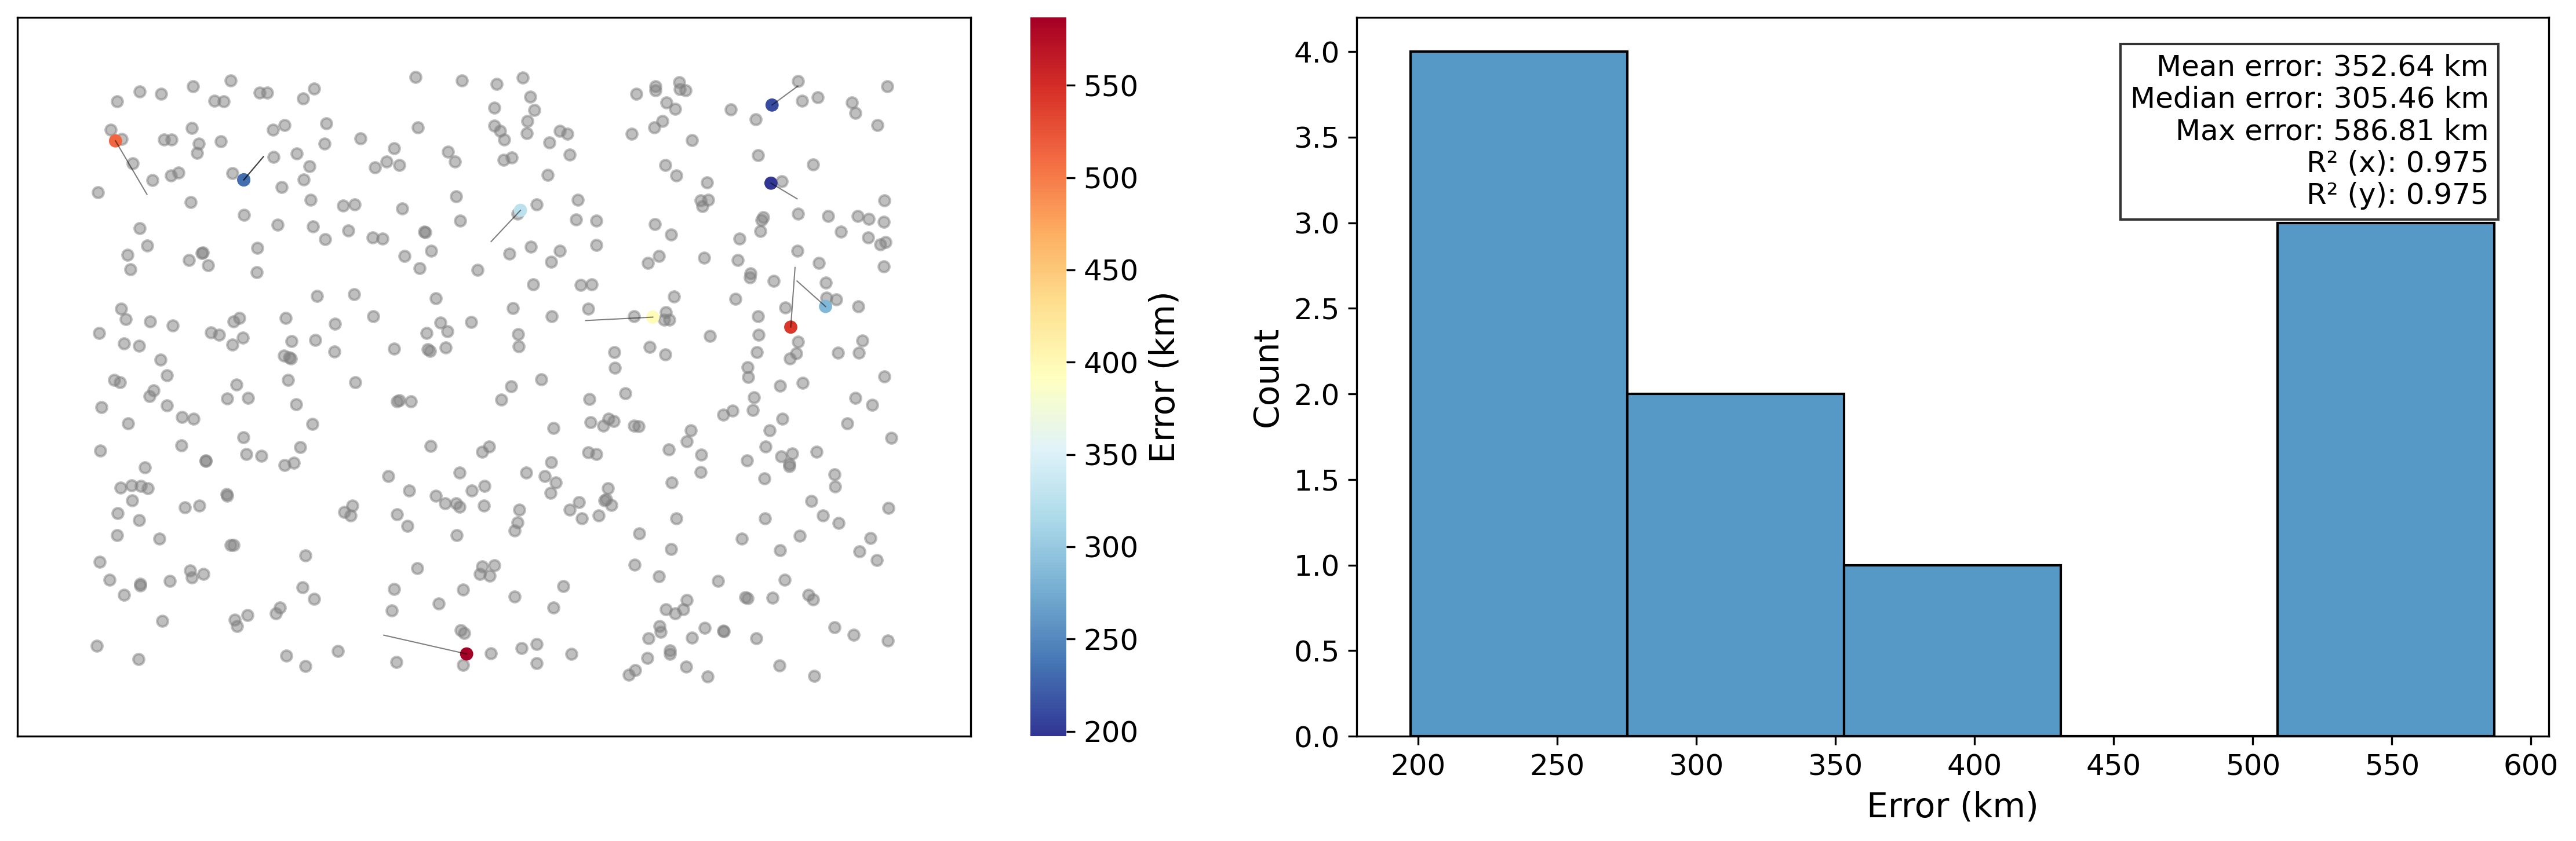

In [7]:
sample_weights = weight_samples(
    method="histogram",
    trainlocs=locator.unnormedlocs,
    trainsamps=locator.trainIDs,
    xbins=5,
    ybins=5
)
locator.set_sample_weights(sample_weights)
locator.train_holdout(genotypes, samples, holdout_indices=idxs)#k=10)
plot_sample_weights(locator, plot_map=False)
predictions = locator.predict_holdout(return_df=True, plot_map=False)


Configuration,Value
train_split,0.9
batch_size,64
min_mac,2
max_SNPs,None
width,256
nlayers,8
dropout_prop,0.25
max_epochs,5000
optimizer_algo,adam
learning_rate,0.001

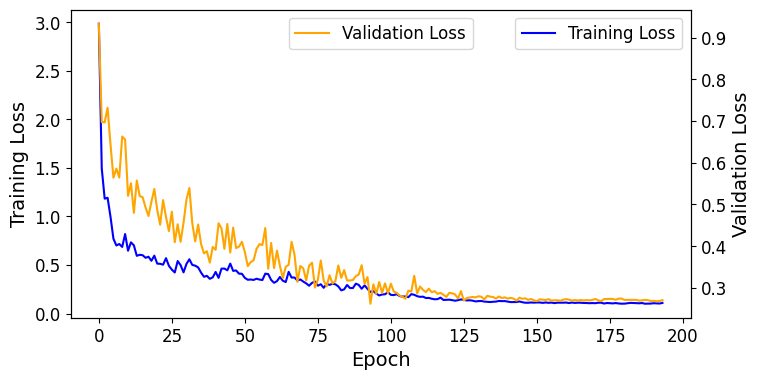

In [8]:
locator


/Users/clararehmann/phd/research/ReLocator/locator/core.py:1355: UserWarning: Sample weights already calculated. 
                    Set locator.sample_weights to None in config to disable.
  warnings.warn(


{'enabled': False, 'flip_rate': 0.05}


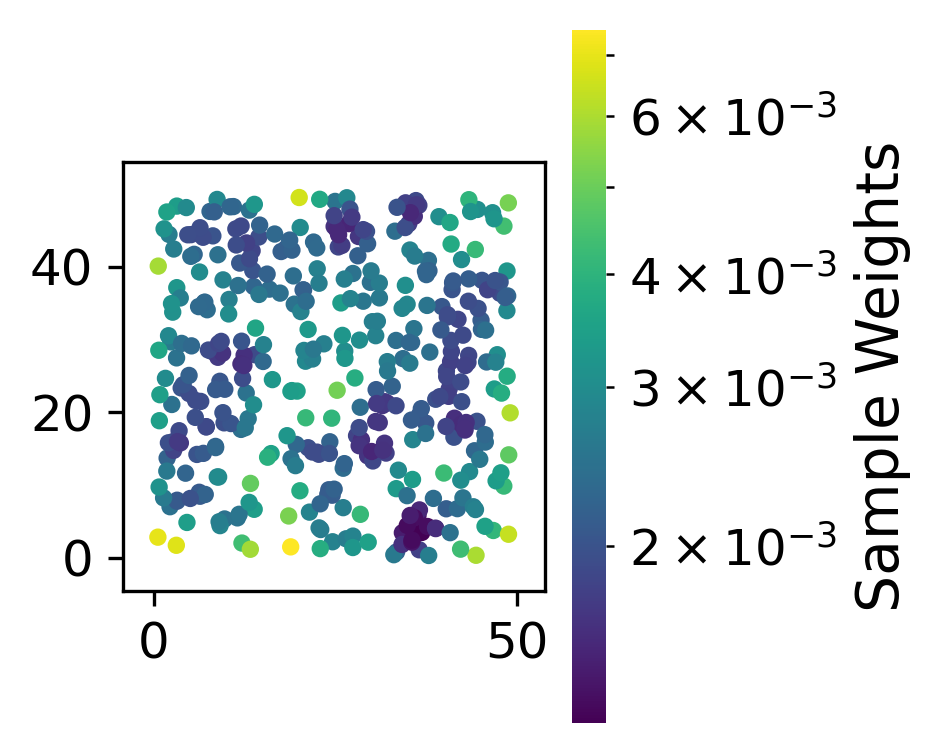

Predicting locations for holdout samples...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


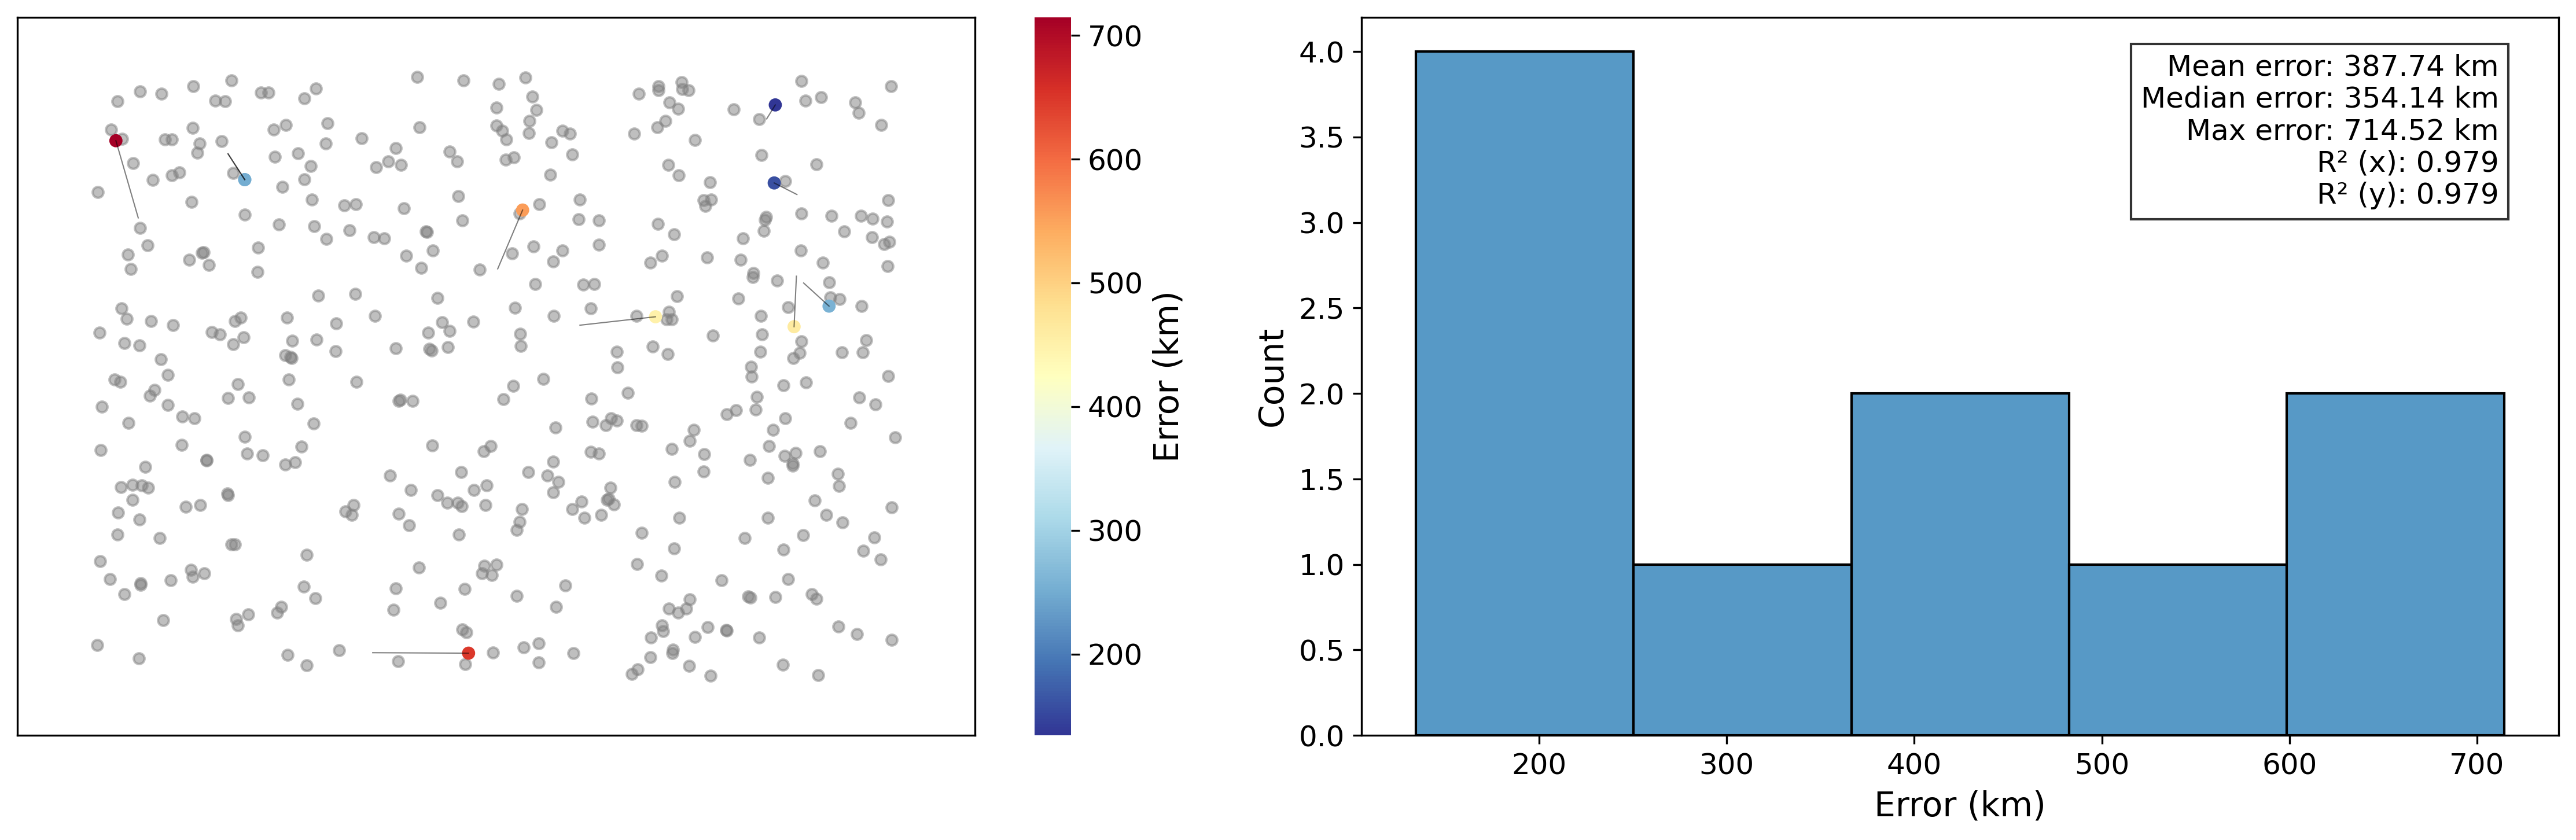

Configuration,Value
train_split,0.9
batch_size,64
min_mac,2
max_SNPs,None
width,256
nlayers,8
dropout_prop,0.25
max_epochs,5000
optimizer_algo,adam
learning_rate,0.001

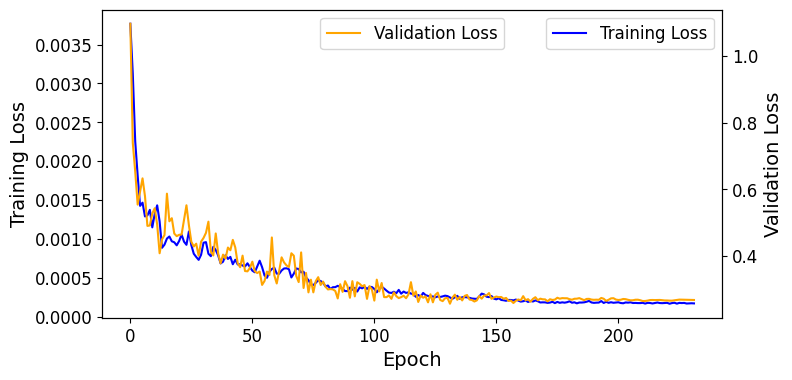

In [9]:
sample_weights = weight_samples(
    method="KD",
    trainlocs=locator.unnormedlocs,
    trainsamps=locator.trainIDs,
)
locator.set_sample_weights(sample_weights)
locator.train_holdout(genotypes, samples, holdout_indices=idxs)#k=10)
plot_sample_weights(locator, plot_map=False)
predictions = locator.predict_holdout(return_df=True, plot_map=False)
locator


/Users/clararehmann/phd/research/ReLocator/locator/core.py:1355: UserWarning: Sample weights already calculated. 
                    Set locator.sample_weights to None in config to disable.
  warnings.warn(


{'enabled': False, 'flip_rate': 0.05}


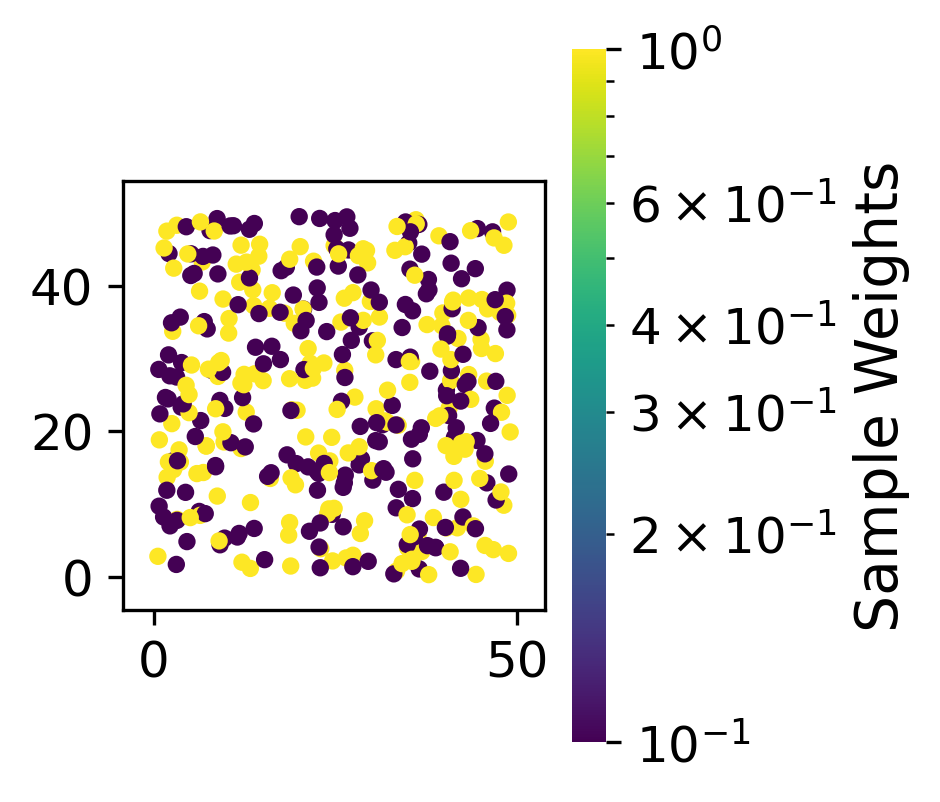

Predicting locations for holdout samples...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


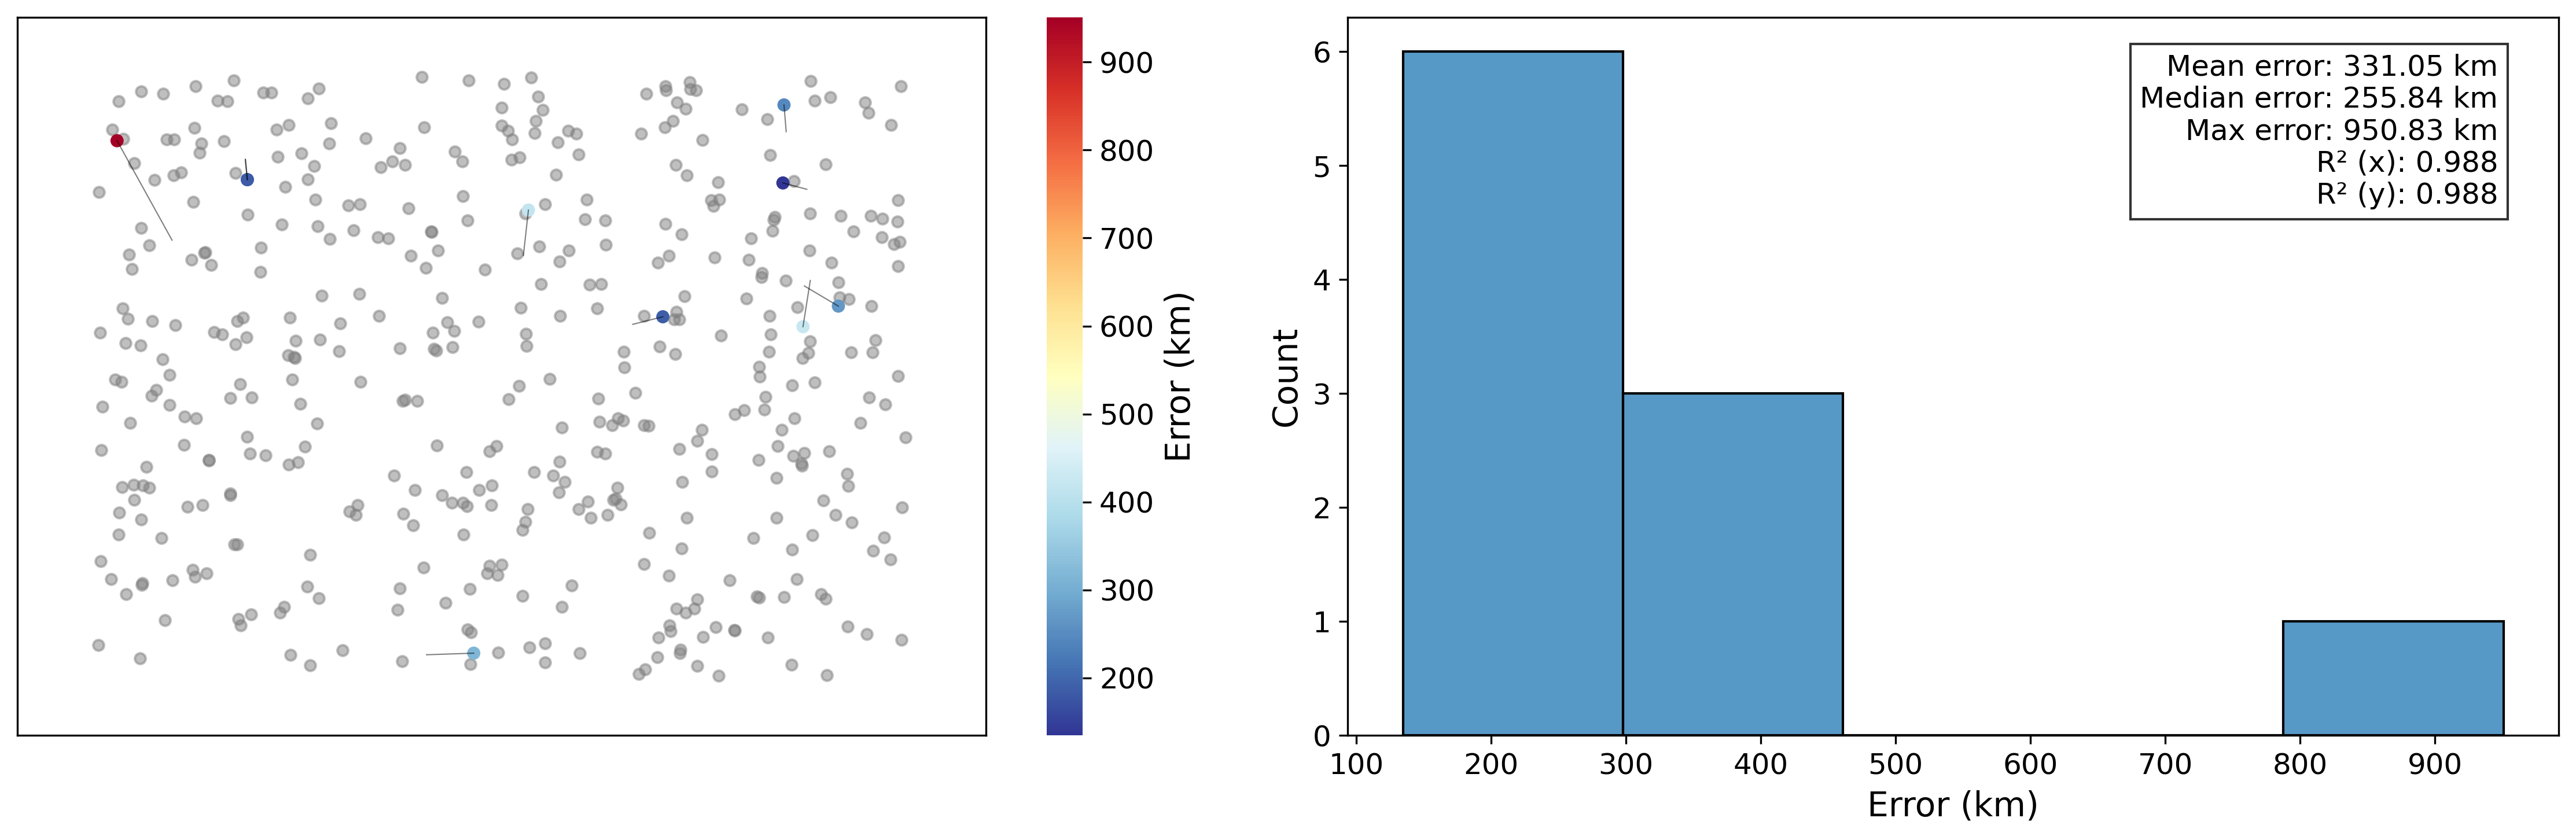

Configuration,Value
train_split,0.9
batch_size,64
min_mac,2
max_SNPs,None
width,256
nlayers,8
dropout_prop,0.25
max_epochs,5000
optimizer_algo,adam
learning_rate,0.001

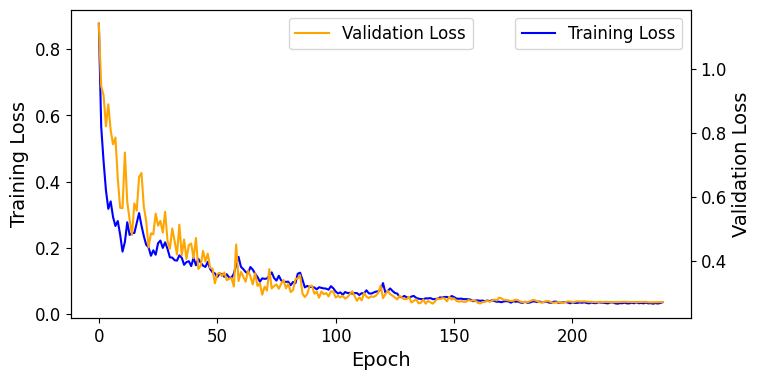

In [10]:
tdf = pd.DataFrame({'sampleID':locator.trainIDs,
                    'sample_weight':np.random.choice([0.1, 1], size=len(locator.trainIDs))})
sample_weights = weight_samples(
    method="load",
    weightdf=tdf,
    trainsamps=locator.trainIDs,
)
locator.set_sample_weights(sample_weights)
locator.train_holdout(genotypes, samples, holdout_indices=idxs)
plot_sample_weights(locator, plot_map=False)
predictions = locator.predict_holdout(return_df=True, plot_map=False)
locator


In [14]:
predictions

,x,y,sampleID,x_pred,y_pred,distance
0,9.401561,42.745872,msp_321,9.401561,42.745872,0.0
1,32.647667,29.182148,msp_75,32.647667,29.182148,0.0
2,42.949787,32.336201,msp_441,42.949787,32.336201,0.0
3,26.084827,34.841728,msp_373,26.084827,34.841728,0.0
4,5.002310,36.105663,msp_117,5.002310,36.105663,0.0
5,43.303585,32.789787,msp_50,43.303585,32.789787,0.0
6,9.401561,42.745872,msp_321,9.401561,42.745872,0.0
7,20.272429,2.000126,msp_328,20.272429,2.000126,0.0
8,43.095001,40.290264,msp_445,43.095001,40.290264,0.0
9,41.856609,45.031734,msp_106,41.856609,45.031734,0.0
